In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.velocity_transformations import equatorial_UVW
from modules.vr_opt import VrOpt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import normalized_mutual_info_score
import hdbscan
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph, sort_graph_by_row_values

from Distant_SigMA.SigMA.SigMA import SigMA
from scipy.stats import norm
from math import ceil
from scipy.stats import gaussian_kde
from sklearn.metrics.cluster import normalized_mutual_info_score

# Generate mock data

In [21]:
# Plotting related stuff
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:grey']
zorders = [2, 2, 2, 2, 2, 1]
alphas = [0.9, 0.9, 0.9, 0.9, 0.9, 0.3]
log = True

In [22]:
# Create 6D Gaussian data
n = 1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50 #background dataset of random points uniformly distributed 6D

mu = np.array([-5, 5, 5, 5, -5, 5]) #first 3 for average position of the Cluster in 3D(XYZ). Last 3 for average velocities in (VxVyVz)
c_xx = c_yy = 20 #Variance of the average in x and y.
c_xy = 15 # correlation of x and y, positive -> there is a correlation 
c_zz = 3 #Variance in z 
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy #makes positive correlation of x and y
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2) #generate n/2 data points based on mu and cov

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

# Additional clusters' parameters
# Cluster 3
mu_3 = np.array([10, -10, -10, -10, 10, -10])
c_xx_3 = c_yy_3 = 25 # More spread in X-Y plane
c_xy_3 = 10
c_zz_3 = 4
cov_3 = np.diag([c_xx_3, c_yy_3, c_zz_3, c_uvw, c_uvw, c_uvw])
cov_3[0, 1] = cov_3[1, 0] = c_xy_3
X_sig_3 = np.random.multivariate_normal(mu_3, cov_3, n//2)

# Cluster 4
mu_4 = np.array([-7, -7, -7, -7, -7, -7])
c_xx_4 = c_yy_4 = 30
c_xy_4 = -12
c_zz_4 = 5
cov_4 = np.diag([c_xx_4, c_yy_4, c_zz_4, c_uvw, c_uvw, c_uvw])
cov_4[0, 1] = cov_4[1, 0] = c_xy_4
X_sig_4 = np.random.multivariate_normal(mu_4, cov_4, n//2)

# Cluster 5
mu_5 = np.array([2, -2, -2, 2, 2, 2])
c_xx_5 = c_yy_5 = 35
c_xy_5 = 8
c_zz_5 = 6
cov_5 = np.diag([c_xx_5, c_yy_5, c_zz_5, c_uvw, c_uvw, c_uvw])
cov_5[0, 1] = cov_5[1, 0] = c_xy_5
X_sig_5 = np.random.multivariate_normal(mu_5, cov_5, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2, X_sig_3, X_sig_4, X_sig_5], axis=0) #5000 bg stars, and 5*500 cluster stars
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2, np.ones(n//2)*3, np.ones(n//2)*4, np.ones(n//2)*5])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_cluster_3 = np.where(labels==3)[0]
idx_cluster_4 = np.where(labels==4)[0]
idx_cluster_5 = np.where(labels==5)[0]
idx_bg = np.where(labels==0)[0]

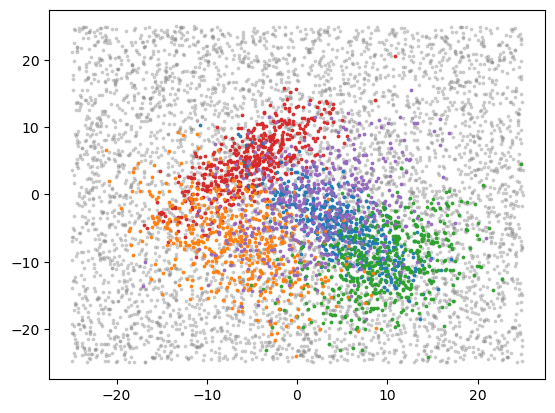

In [23]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
#x_col, y_col = 'pmra', 'pmdec'
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5, idx_bg], alphas, colors, zorders): 
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)

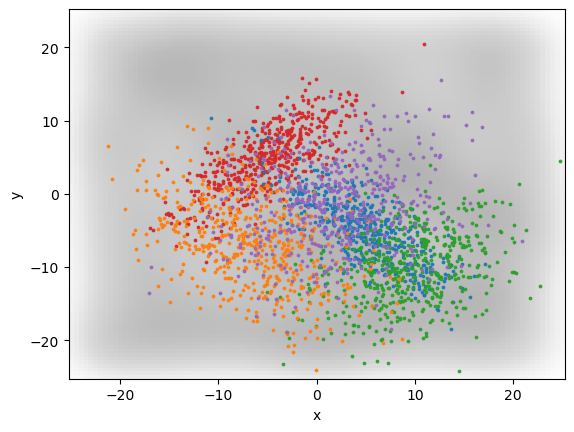

In [24]:
# Select background data (label 0)
X_bg_kde = df.loc[idx_bg, [x_col, y_col]].values.T

# Fit a Gaussian KDE to the background data
kde = gaussian_kde(X_bg_kde)

# Define a grid for plotting the KDE
x_min, x_max = df[x_col].min(), df[x_col].max()
y_min, y_max = df[y_col].min(), df[y_col].max()
X_grid, Y_grid = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))

# Evaluate the KDE on the grid
Z_grid = kde(np.vstack([X_grid.ravel(), Y_grid.ravel()])).reshape(X_grid.shape)

#make background sparse
plt.pcolormesh(X_grid, Y_grid, Z_grid, shading='auto', cmap='Greys', alpha=0.3)

for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5], alphas, colors, zorders): 
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)
    
#plt.xlim(-25000, 25000)
#plt.ylim(-25000, 25000)
plt.xlabel(x_col)#x_col,r'$v_\alpha$ ($km$ $s^{-1}$)'
plt.ylabel(y_col)#y_col,r'$v_\delta$ ($km$ $s^{-1}$)'
plt.show()


In [25]:
U, V, W = equatorial_UVW(
    ra,
    dec,
    pmra,
    pmdec,
    rv_calc,
    dist,
)
# Check if the transformation is correct
np.allclose(U, df.vx.values, atol=1e-1), np.allclose(V, df.vy.values, atol=1e-1), np.allclose(W, df.vz.values, atol=1e-1)
print(df)
df.to_csv('data.csv', index=False)


              x          y          z         vx         vy         vz  \
0     20.285883  24.948489  21.946317  23.733832  21.580861 -20.889111   
1     12.615875  21.300176   3.466524   5.035802  -2.903806 -17.999800   
2     -8.219530   5.199247  19.073583   2.973348 -24.809362  -2.503151   
3    -12.565032  20.673933 -13.977158   3.568924   4.732977  16.579449   
4      7.264760  23.136667 -15.059559  24.367279  10.446721 -12.465359   
...         ...        ...        ...        ...        ...        ...   
7495  -1.340976  -1.170377  -4.978566   1.332841   2.424316   1.488501   
7496   3.415648  -4.454340  -5.173816   2.118777   2.669603   2.020703   
7497   3.533625   3.157564  -4.494831   2.750308   2.603035   2.396998   
7498   8.254748   4.704677   0.625726   2.190305   1.060372   1.906051   
7499  15.791434  11.203979  -1.596717   0.679583   2.274798   3.620799   

              ra        dec       dist        pmra       pmdec  \
0     256.718789  28.923182  38.930515  177.5

# Apply initial clustering of SigMa 

In [26]:
knn_list=[15, 20, 25, 30]
cluster_features = ['x', 'y','z'] #In which variables you want to cluster
sigma_kwargs = dict(
        cluster_features=cluster_features,
        nb_resampling=0,
        max_knn_density=int(np.max(knn_list)+1),
        beta=0.99,
        knn_initcluster_graph=35
    )

In [27]:
#make SigMA object
clusterer = SigMA(
            data=df,
            scale_factors=None, #needed for clustering in different spaces with scaling differences
            **sigma_kwargs
        )

In [28]:
#DO THE INITIAL CLUSTERS WITHOUT THE MERGING STEP OF RUN_SIGMA FUNCTION
clusterer.initialize_clustering(knn=20) #initialen cluster erstellt
clusterer.initialize_mode_neighbor_dict() #diese funktionen und mergeclusterer in parameters.py beschrieben
clusterer.resample_k_distances()# Compute k-distances for re-sampled data sets
leaf_labels = clusterer.leaf_labels_ 

Performing gradient ascend using a 20-NN density estimation.


In [29]:
np.unique(leaf_labels, return_counts = True) #the unique labels and how many in each leaf 

(array([  39,   54,   88,  116,  169,  180,  256,  399,  445,  465,  488,
         509,  606,  640,  835,  837,  922,  933,  985,  986, 1130, 1261,
        1301, 1318, 1427, 1431, 1442, 1498, 1513, 1520, 1545, 1546, 1630,
        1643, 1664, 1667, 1669, 1809, 1812, 1834, 1917, 1940, 1962, 1988,
        2044, 2053, 2075, 2100, 2112, 2262, 2303, 2362, 2393, 2413, 2487,
        2521, 2544, 2584, 2586, 2594, 2606, 2638, 2644, 2749, 2751, 2816,
        2842, 2915, 2958, 2959, 2983, 2998, 3007, 3059, 3066, 3078, 3172,
        3183, 3257, 3263, 3269, 3280, 3333, 3343, 3403, 3422, 3434, 3505,
        3510, 3515, 3570, 3577, 3608, 3682, 3742, 3748, 3754, 3834, 3878,
        3913, 3919, 3972, 3984, 4054, 4063, 4091, 4095, 4124, 4135, 4188,
        4278, 4285, 4457, 4495, 4578, 4579, 4718, 4798, 4801, 4876, 4943,
        5130, 5208, 5344, 5383, 5532, 5546, 5597, 5600, 5704, 5772, 5798,
        6101, 6116, 6158, 6205, 6452, 6454, 6595, 6704, 6763, 6776, 6882,
        6967, 6998, 7002, 7026, 7197, 

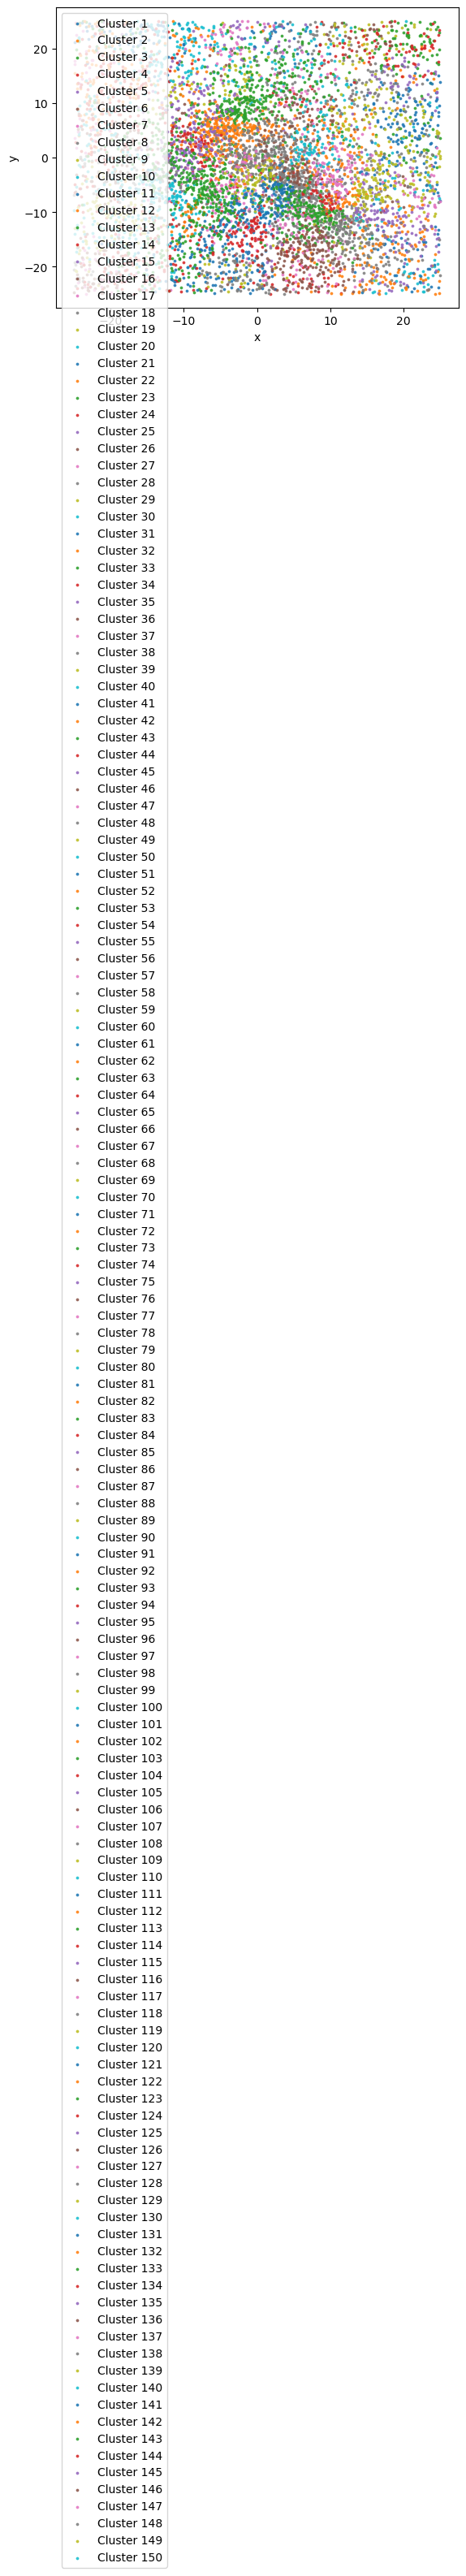

In [30]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
#x_col, y_col = 'pmra', 'pmdec'

for i, label in enumerate(np.unique(leaf_labels)):
    cluster_idx = np.where(leaf_labels == label)[0]  # Get the indices of the current cluster
    plt.scatter(df.loc[cluster_idx, x_col], df.loc[cluster_idx, y_col], 
                s=3, label=f'Cluster {i+1}', alpha=0.8)

# Add plot labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.legend()
plt.show()

# Create initial fine partition:  
Explore hierachy, look into the parameters class (merge_clusters). 
Use run_sigma with -infinity, get pvalues and sort them by icreasing size. 
run mergeclusters fct over and over again using different pvalues (np array distribution btw 0 and 1 zoom in o close to 0 and you get individual values. Choose alpha to be btw the pvalues. whats the center. 
vizualize what it looks like as fct of the alpha value.

In [31]:
#RUN SIGMA WITH P-VALUES
labels_s, pvalues = clusterer.run_sigma(alpha=-np.infty,knn=20,return_pvalues= True) 
sorted_pvalues = sorted(pvalues)

Text(0, 0.5, 'Density')

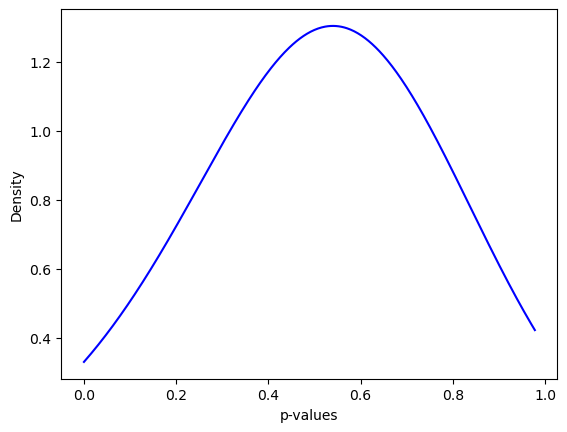

In [32]:
#PLOT DISTRIBUTION OF P-VALUES
mu = np.mean(sorted_pvalues)     
sigma = np.std(sorted_pvalues)    

# Compute the KDE
kde = gaussian_kde(sorted_pvalues, bw_method=1)

x_values = np.linspace(min(sorted_pvalues), max(sorted_pvalues), 500)
density = kde(x_values)

# Plot the normal distribution curve
plt.plot(x_values, density, color='blue')

plt.xlabel('p-values')
plt.ylabel('Density')

In [33]:
# zoom in in the region close to 0
###Ein kleinerer p-Wert bedeutet, dass die beobachteten Daten sehr unwahrscheinlich wären, wenn die Nullhypothese zutrifft###
lower_pvalues = [x for x in sorted_pvalues if x <= 0.2]
#make a list of alpha values that are the centers between all these pvalues
alpha_values = [(lower_pvalues[i] + lower_pvalues[i+1]) / 2 for i in range(len(lower_pvalues) - 1)]
print(lower_pvalues)
print(alpha_values) #Signifikanzniveau

[0.0, 0.0005772544428404025, 0.0011416564945672114, 0.02495185374940123, 0.027381679995020614, 0.029783404509445388, 0.04214442274631991, 0.0533956343824703, 0.05817606167023437, 0.11857846370174807, 0.13059207044502763, 0.16589985116876083, 0.17473078664046482, 0.19026852126547444]
[0.00028862722142020125, 0.000859455468703807, 0.013046755121984221, 0.026166766872210923, 0.028582542252233, 0.03596391362788265, 0.047770028564395106, 0.055785848026352336, 0.08837726268599122, 0.12458526707338785, 0.14824596080689423, 0.17031531890461282, 0.18249965395296963]


[2100 5130]
[2100 3059 5130]
[2100 3059 5130 6882]
[1520 2100 3059 5130 6882]
[1520 2100 3059 5130 6101 6882]
[1520 2100 3059 4285 5130 6101 6882]
[  39 1520 2100 3059 4285 5130 6101 6882]
[  39   88 1520 2100 3059 4285 5130 6101 6882]
[  39   88 1520 2100 3059 3515 4285 5130 6101 6882]
[  39   88 1301 1520 2100 3059 3515 4285 5130 6101 6882]
[  39   88 1301 1520 2100 3059 3515 4285 5130 5597 6101 6882]
[  39   88 1301 1520 1667 2100 3059 3515 4285 5130 5597 6101 6882]
[  39   88 1301 1520 1667 1812 2100 3059 3515 4285 5130 5597 6101 6882]


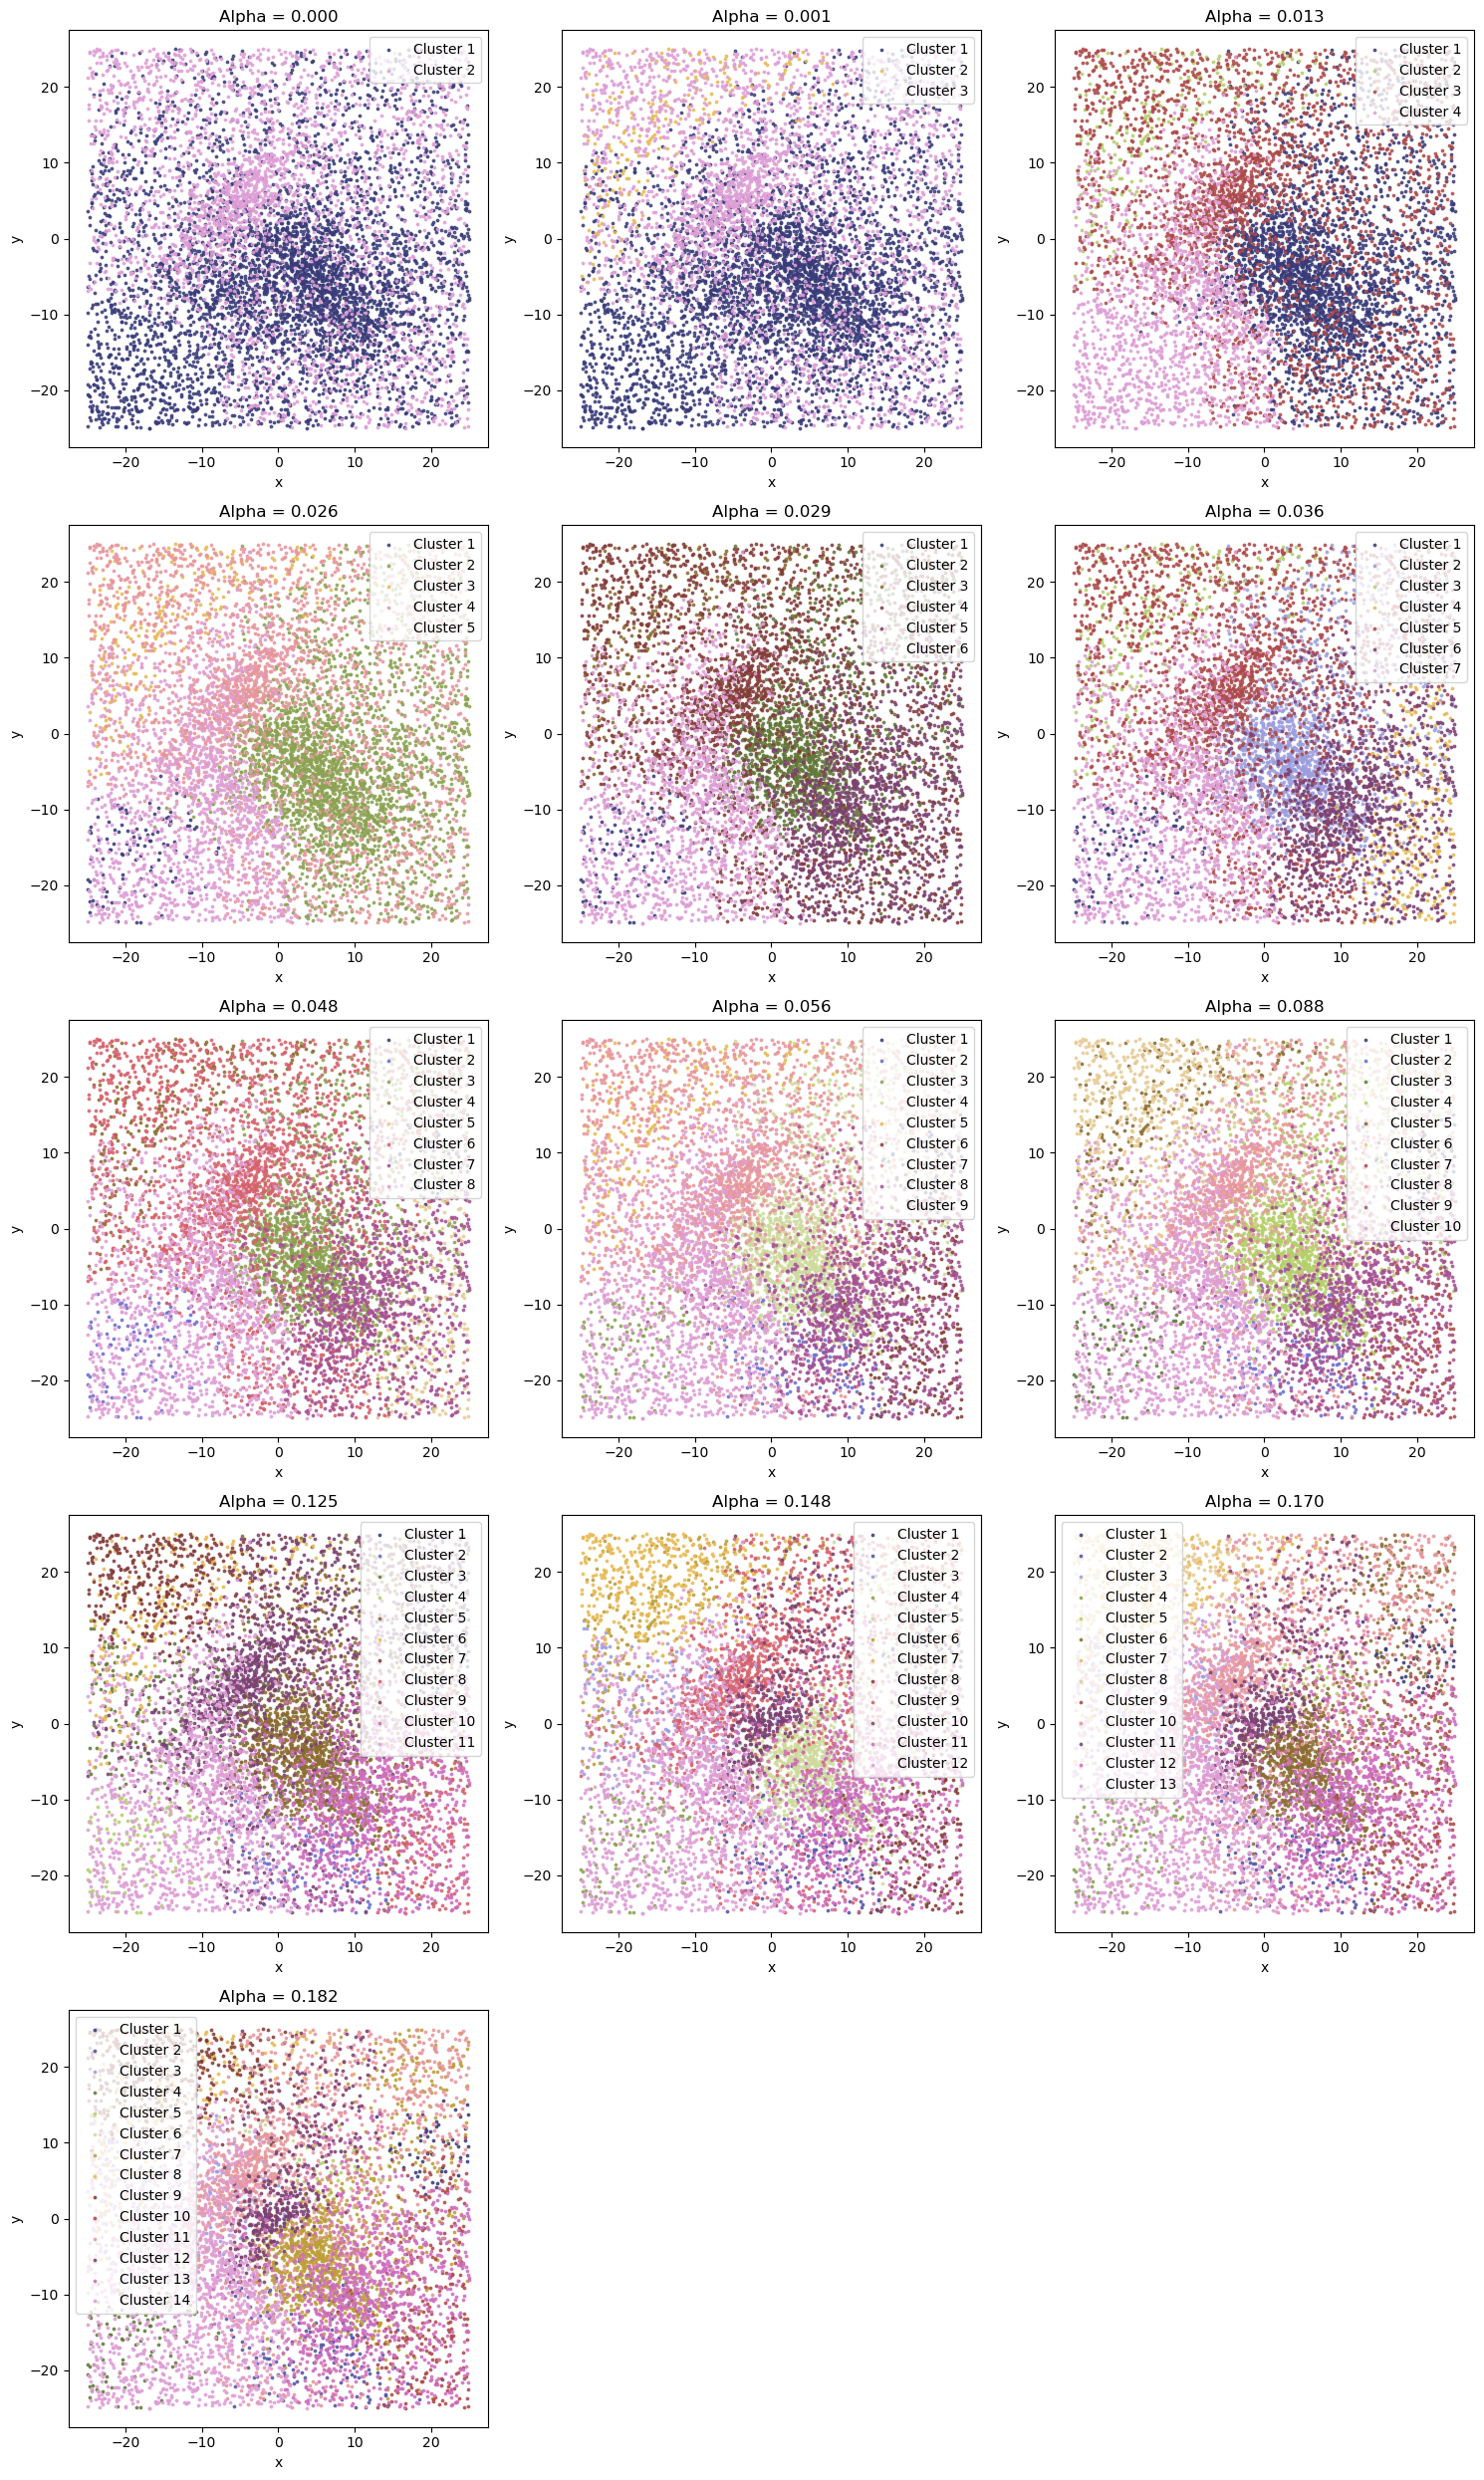

In [34]:
# dictionary to store results of merge_clusters for each alpha
merged_results = {}

# Run merge clustering for each alpha and store results
for alpha in alpha_values:
    merged_labels, merged_pvalues = clusterer.merge_clusters(knn=20, alpha=alpha)
    merged_results[alpha] = {
        "labels": merged_labels,
        "pvalues": merged_pvalues
    }

n_alpha = len(alpha_values)
cols = 3
rows = ceil(n_alpha / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axs.flatten()

for i, alpha in enumerate(alpha_values):
    merged_labels = merged_results[alpha]["labels"]
    unique_labels = np.unique(merged_labels)
    print(unique_labels)

    cmap = plt.get_cmap('tab20b', len(unique_labels))
    ax = axs[i]

    for j, label in enumerate(unique_labels):
        cluster_idx = np.where(merged_labels == label)[0]
        ax.scatter(df.loc[cluster_idx, x_col], df.loc[cluster_idx, y_col],
                   s=3, label=f'Cluster {j+1}', alpha=0.8, color=cmap(j))

    ax.set_title(f'Alpha = {alpha:.3f}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()

# Hide unused subplots
for ax in axs[n_alpha:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# How are real labels represented in unique labels  


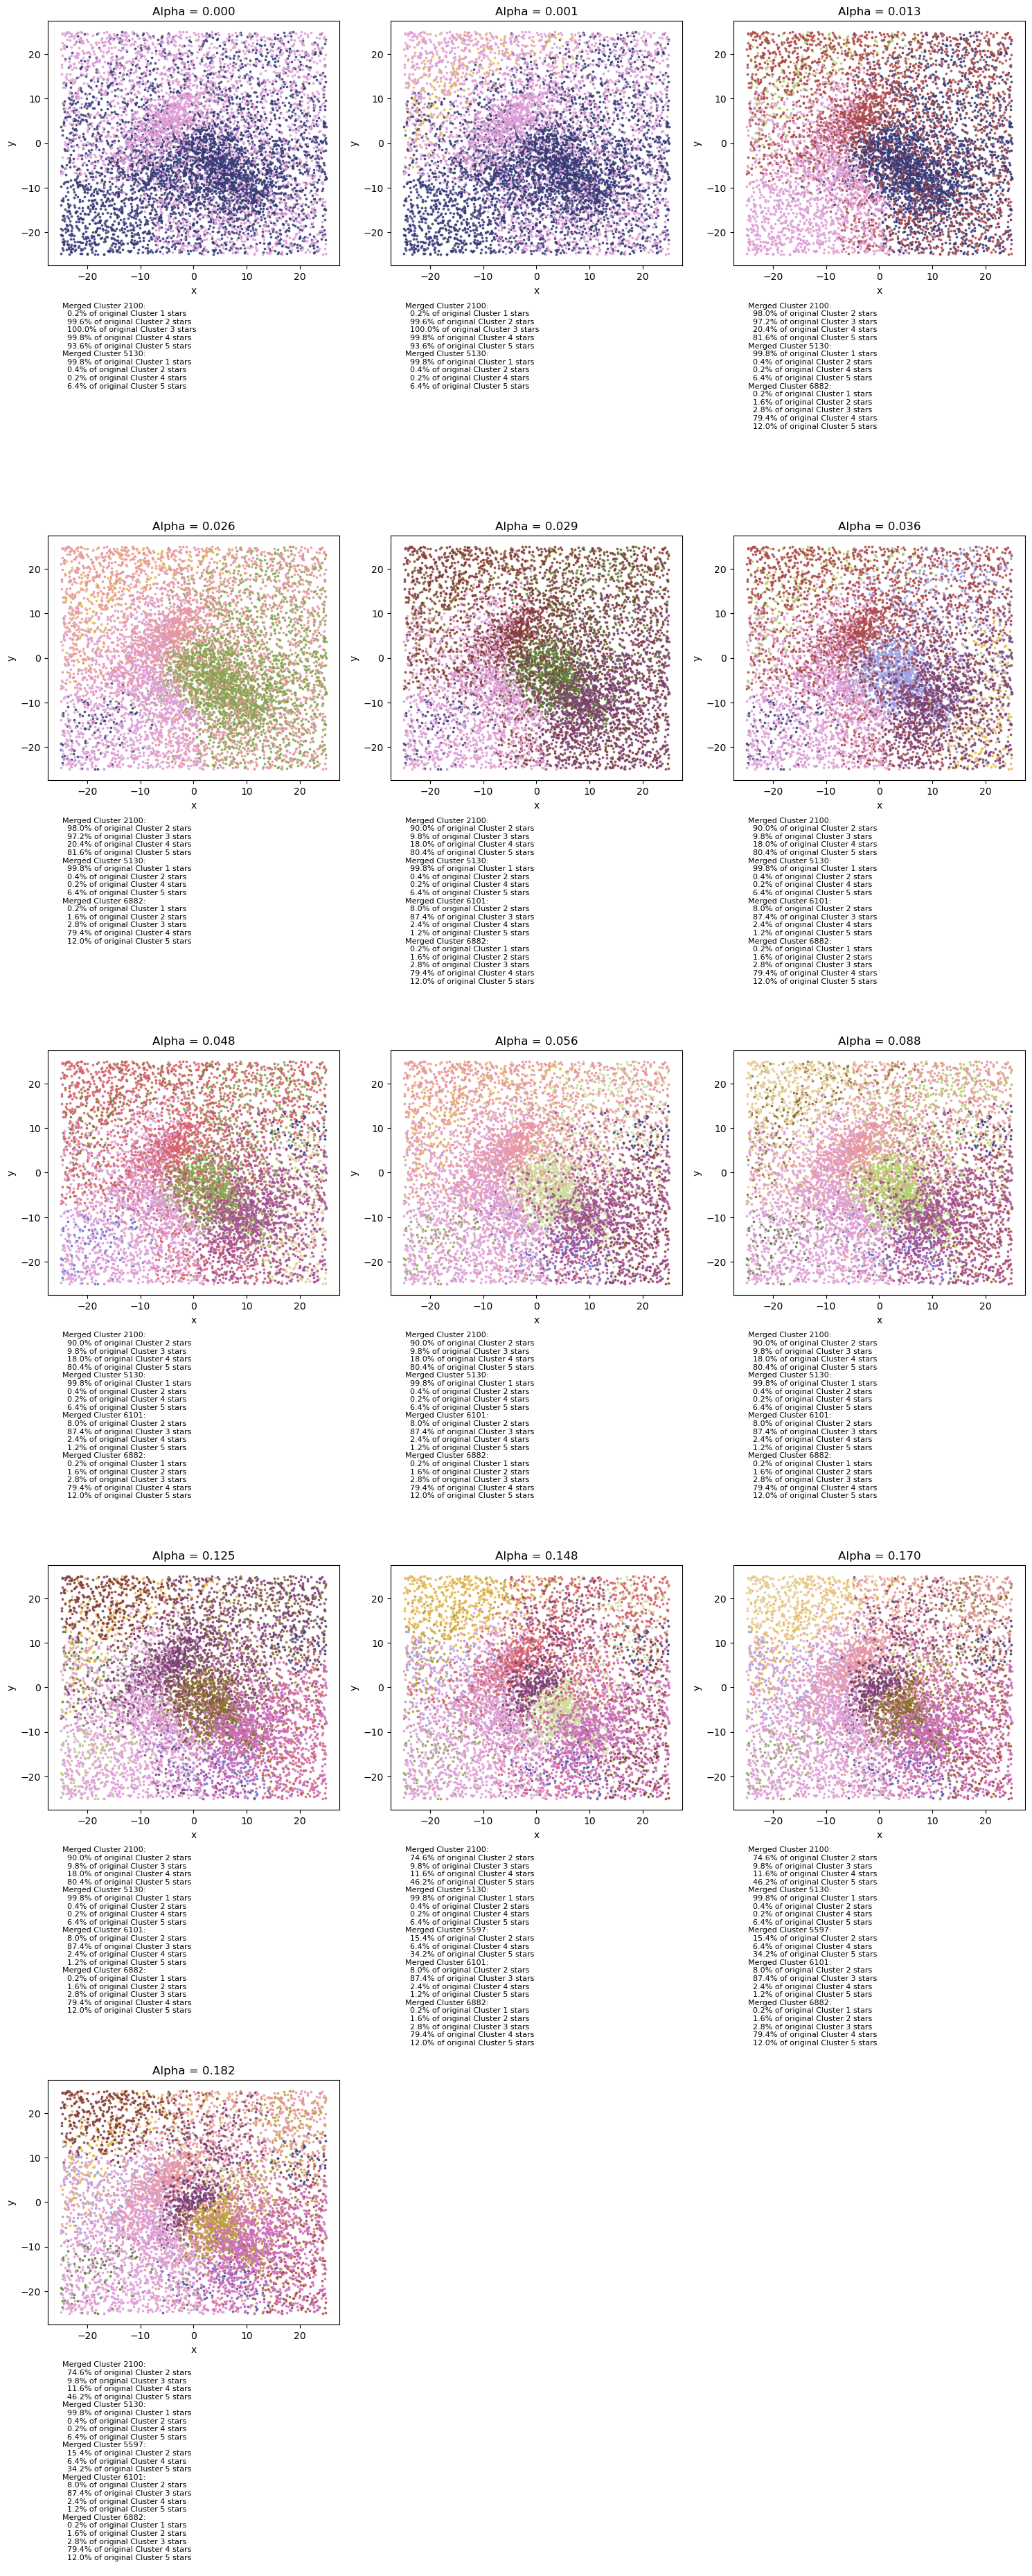

In [35]:
fig, axs = plt.subplots(rows, cols, figsize=(15, 7.5 * rows))
axs = axs.flatten()

# original clusters as dictionary
original_clusters = {
    1: idx_cluster_1,
    2: idx_cluster_2,
    3: idx_cluster_3,
    4: idx_cluster_4,
    5: idx_cluster_5
}

for i, alpha in enumerate(alpha_values):
    merged_labels = merged_results[alpha]["labels"]
    unique_labels = np.unique(merged_labels)
    cmap = plt.get_cmap('tab20b', len(unique_labels))

    # Initialize dictionary to store cluster distribution for display
    cluster_distribution = {}
    ax = axs[i]

    for j, label in enumerate(unique_labels):
        cluster_idx = np.where(merged_labels == label)[0]
        ax.scatter(df.loc[cluster_idx, x_col], df.loc[cluster_idx, y_col],
                   s=3, label=f'Cluster {j+1}', alpha=0.8, color=cmap(j))

        # Calculate distribution of original clusters within this merged cluster
        cluster_distribution[label] = {}
        for original_label, original_indices in original_clusters.items():
            common_indices = np.intersect1d(cluster_idx, original_indices)
            percentage = len(common_indices) / len(original_indices) * 100 if len(original_indices) > 0 else 0
            if percentage > 0:
                cluster_distribution[label][original_label] = percentage

    merge_info = ""
    for merged_label, distribution in cluster_distribution.items():
        if distribution:  # Only add if there's a non-zero percentage from any original clusters
            merge_info += f"Merged Cluster {merged_label}:\n"
            for original_label, percentage in distribution.items():
                merge_info += f"  {percentage:.1f}% of original Cluster {original_label} stars\n"

    ax.set_title(f'Alpha = {alpha:.3f}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.text(0.05, -0.15, merge_info, transform=ax.transAxes, fontsize=8, verticalalignment='top', wrap=True)

# Hide unused subplots
for ax in axs[n_alpha:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


# NMI plot (normalized_mutual_info_score)

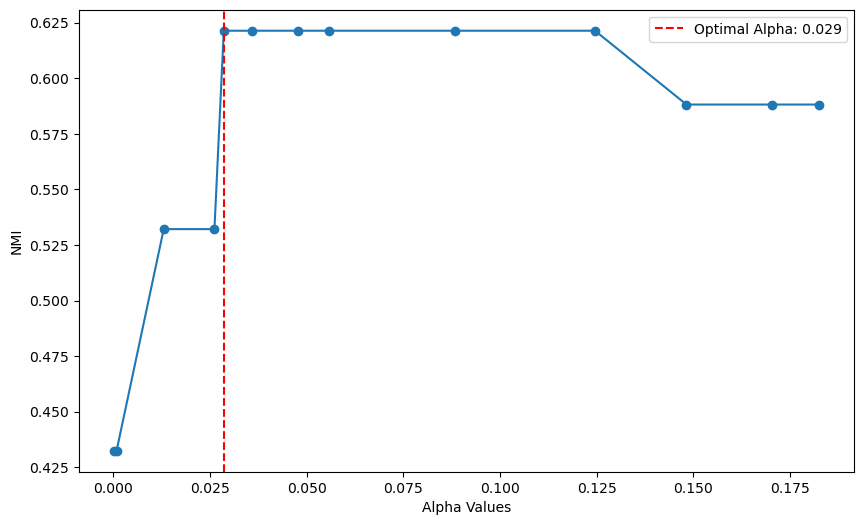

Optimal Alpha: 0.029 with NMI: 0.621


In [36]:
#nmi sklearn für jedes splitting (alle labels die nicht 0 sind bei lab_t)
#nmi plot all merged to all split -> alpha ausrechnen - kann auch alpha auf x (nicht equidistant) -> berechne opt alpha 

labels_true = labels

# Calculate NMI for each alpha value
nmi_scores = []
optimal_alpha_index = -1
max_nmi = -1

for alpha in alpha_values:
    labels_pred = merged_results[alpha]["labels"]
    # Extract true labels ignoring noise (Bg = 0)
    filtered_true_labels = labels_true[labels_true != 0]
    filtered_pred_labels = labels_pred[labels_true != 0]

    nmi = normalized_mutual_info_score(filtered_true_labels, filtered_pred_labels)
    nmi_scores.append(nmi)

    # Compute optimal alpha
    if nmi > max_nmi:
        max_nmi = nmi
        optimal_alpha_index = len(nmi_scores) - 1  # Index of the best NMI score

# Plotting NMI against alpha values
plt.figure(figsize=(10, 6))
plt.plot(alpha_values[:len(nmi_scores)], nmi_scores, marker='o')
plt.xlabel('Alpha Values')
plt.ylabel('NMI')
plt.axvline(alpha_values[optimal_alpha_index], color='r', linestyle='--', label=f'Optimal Alpha: {alpha_values[optimal_alpha_index]:.3f}')
plt.legend()
plt.show()

# Output the optimal alpha
optimal_alpha = alpha_values[optimal_alpha_index]
print(f'Optimal Alpha: {optimal_alpha:.3f} with NMI: {max_nmi:.3f}')

In [37]:
print(nmi_scores)

[0.4324313909155517, 0.4324313909155517, 0.5321278600904535, 0.5321278600904535, 0.6213839581576989, 0.6213839581576989, 0.6213839581576989, 0.6213839581576989, 0.6213839581576989, 0.6213839581576989, 0.5881744672367167, 0.5881744672367167, 0.5881744672367167]


In [38]:
#branch luisa - softmax optimized - lass auf deinem datenset laufen, berechne G (est Vropt) -> berechne dist Vopt 
# -> bau triag matrix mit indices len(X) -> nxn matrix mit opt distances 
# pi opt ist clustering ergebnis 
# K=6 (sie hat 6 cluster )  KxN matrix
#get clusters fct. entfernt spalten mit nur 0 
#plot ergebnis wie bei ihr in 36 
#ursprl. 5 cluster werden getrennt plus 6. cluster mit nur noise 
#B) lass nich auf ganzes laufen aber auf die sets wie hier  - berechne G bei zb in 2 gesplitteten G1 G2 (man muss mit ind spielen)
# lass softmax wieder laufen - wie gut clustering ergebnis ? nmi ?
#labels_softmax_opt für G1 und G2 -> merge cluster result von G1 G2 
#pass auf mit indizes 01 eg 012 -> 234
#nmi - wie ist kurve - wird es besser - trenn mehr auf (komplett seperate zellen betrachten aber evt. 1 cluster komm in mehreeren zellen vor)
#annahme nmi nimmt ab

#iphd 